In [ ]:
# MLflow, Bayesian Hyperparameters Tuning

#assumption: NOT using colab, using local server/machine instead
#otherwise, create remote tunnel using ngrok.com to allow local port access
!pip install torch matplotlib numpy pandas
!pip install pytorch_lightning
!pip install mlflow

#note: see warnings here, and add certain dir path to PATH in system environment variables if needed

In [ ]:
pip show mlflow

In [7]:
import mlflow
print(mlflow.__version__)

# run tracking UI in the background
#get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background
#above may not work in some systems/environments
#tried this in Windows
import os
#os.system("start mlflow --version")
os.system("start mlflow ui --port 5000")
#if still doesn't work, just run "mlflow ui --port 5000" above in a separate command prompt/terminal
#.. or: may need to run in Windows PowerShell instead of cmd

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
# -> go to web browser and enter the URL above


3.6.0


0

In [6]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [6]:
#no need to do these as colab is NOT used in this case
#from google.colab import drive
#drive.mount('/content/drive')

In [10]:
#emnist_train_data  = pd.read_csv("/content/drive/MyDrive/emnist_data/emnist-letters-train.csv")
#emnist_test_data = pd.read_csv("/content/drive/MyDrive/emnist_data/emnist-letters-test.csv")
emnist_train_data  = pd.read_csv("./emnist_data/emnist-letters-train.csv")
emnist_test_data = pd.read_csv("./emnist_data/emnist-letters-test.csv")

In [8]:
class EMNISTDataset(Dataset):
    def __init__(self, dataframe):

        self.images = torch.tensor(dataframe.iloc[:, 1:].values, dtype= torch.float32)

        self.labels = torch.tensor(dataframe.iloc[:, 0].values, dtype = torch.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        images = self.images[idx]

        images = images / 255.0
        labels = self.labels[idx]

        return images, labels

In [11]:
emnist_test_data = emnist_test_data.sample(frac = 1)

In [12]:
train_dataset = EMNISTDataset(emnist_train_data)
test_dataset = EMNISTDataset(emnist_test_data )

In [13]:
from torch.utils.data import random_split

val_percent = 0.1
val_len = int(val_percent * len(train_dataset))

train_ds, val_ds = random_split(train_dataset, [len(train_dataset) - val_len, val_len])

In [12]:
'''
batch_size = 64

train_dataloader = DataLoader(train_ds, batch_size, shuffle = True, drop_last = True, num_workers=1)

val_dataloader = DataLoader(val_ds, batch_size, num_workers=1)

test_dataloader = DataLoader(test_dataset, batch_size, num_workers=1)

len(train_dataloader), len(val_dataloader), len(test_dataloader)
'''

'\nbatch_size = 64\n\ntrain_dataloader = DataLoader(train_ds, batch_size, shuffle = True, drop_last = True, num_workers=1)\n\nval_dataloader = DataLoader(val_ds, batch_size, num_workers=1)\n\ntest_dataloader = DataLoader(test_dataset, batch_size, num_workers=1)\n\nlen(train_dataloader), len(val_dataloader), len(test_dataloader)\n'

In [15]:
#changed to this for now (num_workers=0 instead of 1):
batch_size = 64
train_dataloader = DataLoader(train_ds, batch_size, shuffle = True, drop_last = True, num_workers=0)
val_dataloader = DataLoader(val_ds, batch_size, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=0)
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(1248, 139, 232)

In [16]:
#for debug: test one batch to see exact exception - num_workers=0 works BUT NOT num_workers=1
try:
    batch = next(iter(train_dataloader))
    x, y = batch
    print("batch shapes:", x.shape, y.shape, "dtypes:", x.dtype, y.dtype)
except Exception as e:
    import traceback
    traceback.print_exc()

batch shapes: torch.Size([64, 784]) torch.Size([64]) dtypes: torch.float32 torch.float32


In [17]:
#importing necessary libraries for model training
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl

from torchmetrics.functional import accuracy

In [ ]:
import mlflow #if not already imported

#experiment_id = mlflow.create_experiment(name = "emnist_letters_prediction_using_cnn")
#above needs to be created only once, needs to be commented after first run

mlflow.set_experiment(experiment_name = "emnist_letters_prediction_using_cnn")

Defining Lightning Module for Letter classification. Model is CNN and metrics are logged using log method of lightning

In [19]:
class EmnistModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.criterion = nn.CrossEntropyLoss()

        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 64 * 14 * 14

            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #256 * 7 * 7

            nn.Flatten(),
            nn.Linear(256*7*7, 32),
            nn.ReLU(),

            nn.Linear(32, 64),
            nn.ReLU(),

            nn.Linear(64, 26)
        )

    def forward(self, xb):
        return self.network(xb.reshape(-1, 1, 28, 28))

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr = 0.0001)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x) #this invokes "forward" above, just like the original nn.Module
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim = 1)

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26)

        self.log("train_loss", loss, on_epoch = True, prog_bar = True)
        self.log("train_acc", acc, on_epoch = True, prog_bar = True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim = 1)

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26)

        self.log("valid_loss", loss, on_epoch = True, prog_bar = True)
        self.log("valid_acc", acc, on_epoch = True, prog_bar = True)

        return acc

    def test_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim = 1)

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26)

        self.log("test_loss", loss, logger = True)
        self.log("test_acc", acc, logger = True)

        return acc


    def predict_step(self, batch, batch_idx, dataloader_idx = 0):
        x, y = batch

        return self(x)

Model Training is done  with Trainer and All parameters are autologged using mlflow autologging and Trained Model is logged separately with defined Signature with input and output schema. Model metrics are also separately logged using CSV logger. Training is done for 10 epochs and then Model is tested on Test dataloader

In [ ]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import ColSpec, Schema, TensorSpec
from pytorch_lightning.loggers import CSVLogger

emnist_model = EmnistModel()

logger = CSVLogger("logs", name = "emnist_letters_classification") #to track the model metrics

trainer = pl.Trainer(max_epochs = 10, logger = logger)

mlflow.pytorch.autolog(log_models = False)

with mlflow.start_run() as run:

    trainer.fit(emnist_model, train_dataloader, val_dataloader)
    trainer.test(dataloaders = test_dataloader)

    input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 1, 28, 28))])
    output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 26))])
    signature = ModelSignature(inputs = input_schema, outputs = output_schema)

    mlflow.pytorch.log_model(emnist_model, "emnist-letters-classifier-cnn-model", signature = signature)

- in the webbrowser opened above, click into the specific experiment
- such experiment was named above as: emnist_letters_prediction_using_cnn
- add new columns there as needed
- IMPORTANT: see the charts by clicking the chart tab
- click into each specific run and see everything logged
- on top of the overview tab, check out the artifacts tab as well

As the hyperparameter tuning above is running go to the MLflow UI
- Select the current experiment
- Show that the outer run appears with a +, expand and show the inner run
- Click on the + next to the metrics and add test_acc, train_acc, valid_acc
- Stay on the page and hit refresh till 2-3 runs complete
- Click through to a run and show the metrics there
- Come back to the main experiments page and click on refresh
- Click on Chart and hide all EXCEPT 2 runs
- .. and try to compare those two runs in the charts


Logged metrics dataframe is obtained

In [21]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
#metrics

Accuracy and Loss are plotted wrt epochs

In [ ]:
!pip install seaborn

<Axes: xlabel='epoch'>

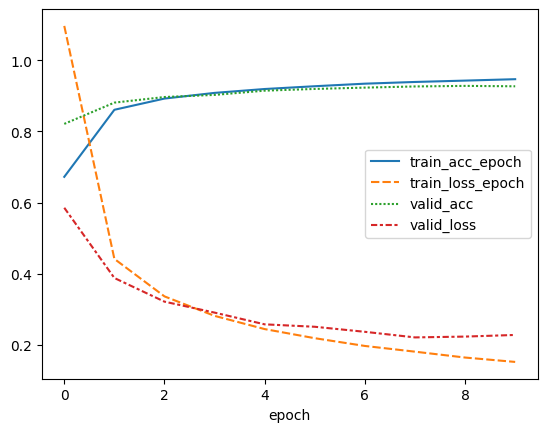

In [22]:
import seaborn as sns

# Set the epoch column as the index, for easier plotting
metrics.set_index("epoch", inplace = True)
metrics.drop(columns = ['step', 'train_loss_step',
                        'train_acc_step', 'test_acc', 'test_loss'], inplace = True)
# Create a line plot of the training metrics using Seaborn
sns.lineplot(data = metrics)

Obtaining last active run id

In [23]:
run_id = mlflow.last_active_run().info.run_id

run_id

'fd92da94e9324f709a1c78554528d108'

Batch of test images are loaded

In [24]:
test_dataiter = iter(test_dataloader)

test_imgs, test_labels = next(test_dataiter)

test_imgs.shape, test_labels.shape

(torch.Size([64, 784]), torch.Size([64]))

Predictions are obtained which are logits

In [25]:
logged_model = f'runs:/{run_id}/emnist-letters-classifier-cnn-model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

predictions = loaded_model.predict(test_imgs.numpy().reshape(-1, 1, 28, 28))

predictions[:5]

array([[  4.1252737 ,  14.713531  ,  -7.7230387 ,  -0.9648938 ,
          3.1785078 ,  -8.77919   ,   2.882217  ,  -8.3502    ,
         -4.3241496 ,  -4.3086834 ,  -9.7411    ,  -2.3670895 ,
        -12.166426  ,  -9.08271   ,  -4.4849267 ,   0.5560144 ,
         -2.380334  ,  -1.5062068 ,  -0.59156644,  -9.964025  ,
         -6.9818096 , -10.98478   ,  -9.780545  ,  -8.430052  ,
         -9.275522  ,   2.6930385 ],
       [  3.1270254 ,   2.0508273 ,  -4.07686   ,  -3.847963  ,
          4.0536966 ,  -5.2889733 ,  -0.8842263 ,  -1.4522222 ,
         -7.954979  , -17.940557  ,   7.709137  ,   0.24319531,
         -5.375799  ,   1.880073  , -13.069029  ,   3.9284368 ,
         -0.13631493,  14.95841   , -18.282248  ,  -8.140786  ,
         -1.4800578 , -11.903902  , -12.691743  ,  -1.2639892 ,
        -10.514639  ,   1.4493412 ],
       [ -4.087494  ,  -2.5861783 ,  -4.116864  ,  -1.8747126 ,
         -5.294181  ,  -2.8994138 ,  -1.2424179 ,  -3.0745373 ,
          8.084437  ,   3.1036

In [26]:
predictions.shape

(64, 26)

For one instance,Actual label is checked and note that for obtaining class we need to subtract label value by 1

In [27]:
test_labels[2]

tensor(9.)

In [28]:
classes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [28]:
classes[int(test_labels[2].item())-1]

'e'

predicted label is checked which is same as actual label

In [29]:
predictions[2]

array([ -4.087494  ,  -2.5861783 ,  -4.116864  ,  -1.8747126 ,
        -5.294181  ,  -2.8994138 ,  -1.2424179 ,  -3.0745373 ,
         8.084437  ,   3.1036358 ,  -3.777567  ,   5.3198605 ,
       -13.472893  ,  -1.0424179 ,  -2.6142642 ,  -2.705131  ,
        -1.3214114 ,  -0.11087845,   1.9479642 ,  -1.4587104 ,
        -3.0388677 ,   0.50310415,  -5.518798  ,  -1.4641379 ,
        -0.03039424,  -2.7509336 ], dtype=float32)

In [30]:
classes[np.argmax(predictions[2])]

'i'

Defining a function for displaying predicted and actual labels for a batch of images

In [31]:
def show(idx, title):

    plt.figure()
    plt.imshow(test_imgs.squeeze()[idx].numpy().reshape( 28, 28), cmap = "gray")

    plt.axis("off")
    plt.title("\n\n{}".format(title), fontdict = {"size": 16})

We can observe a batch of images for comparing its predicted label with actual label

In [ ]:
for i in range(64):
    predicted_class = np.argmax(predictions[i])
    actual_class = test_labels[i].long().item()-1

    show(i, "Model prediction {} (class {}), actual category {} (class {})".format(
          classes[predicted_class], predicted_class,
          classes[actual_class], actual_class
    ))

Accuracy on test data: 0.9162781269004663


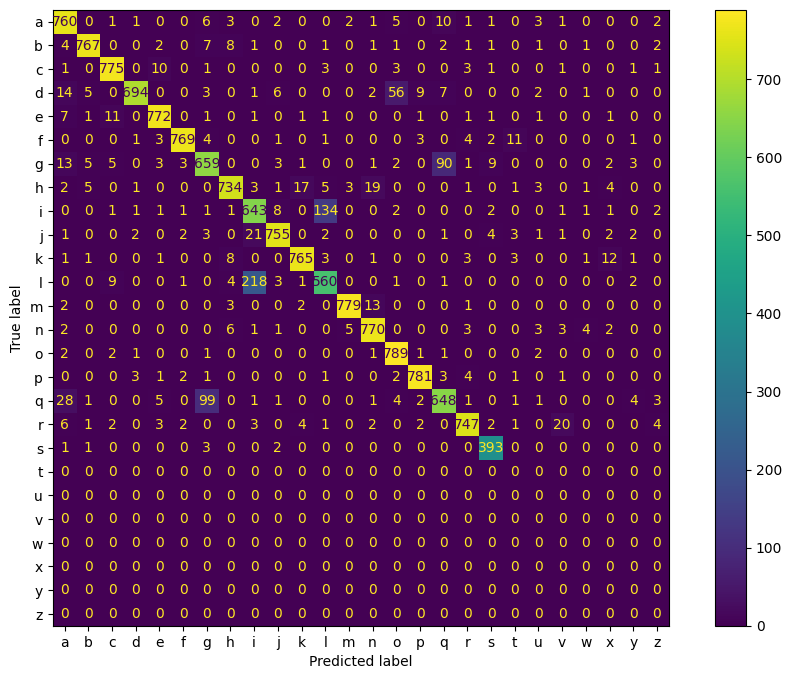

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        output = loaded_model.predict(inputs.numpy().reshape(-1, 1, 28, 28)) # Feed Network

        output = np.argmax(output, axis = 1).astype("float64").tolist()
        y_pred.extend(output)

        labels = [ x-1 for x in labels.tolist()]
        y_true.extend(labels)

acc = accuracy_score(y_true, y_pred)
print('Accuracy on test data:', acc)

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels = classes)

fig, ax = plt.subplots(figsize = (12, 8))
cmp.plot(ax = ax)

Just checking the test accuracy manually which is same as obtained by trainer.test

In [34]:
np.trace(cm) / len(test_dataset)

np.float64(0.9162781269004663)

Defining the search space for hyperparameters using Hyperopt.
we are tuning learning rate, and l1 and l2 which are input and output size for Linear layers coming in deep layers

In [ ]:
!pip install hyperopt

In [35]:
from hyperopt import fmin, tpe, hp, Trials
#Hyperopt is for hyperparameter optimization. 
#Hyperopt uses a form of Bayesian optimization for hyperparameter tuning.

search_space = {
    # Learning rate in log space
    "lr": hp.loguniform("lr", -10, -8),
    #"l1": hp.choice("l1", [32, 64, 128]),
    #"l2": hp.choice("l2", [64, 128, 256]),
    "l1": hp.choice("l1", [64, 128]), #limiting the search space for faster tuning for now
    "l2": hp.choice("l2", [128, 256]),
}

Defining the Lightning Module for tuning. Using save_hyperparameters() within your LightningModule’s __init__ method. It will enable Lightning to store all the provided arguments under the self.hparams attribute. These hyperparameters will also be stored within the model checkpoint, which simplifies model re-instantiation after training.

In [37]:
class EmnistModel(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()

        self.save_hyperparameters(hparams)

        self.criterion = nn.CrossEntropyLoss()

        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #64*14*14

            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #256*7*7

            nn.Flatten(),
            nn.Linear(256*7*7, self.hparams["l1"]),
            nn.ReLU(),
            nn.Linear(self.hparams["l1"], self.hparams["l2"]),
            nn.ReLU(),
            nn.Linear(self.hparams["l2"], 26)
        )

    def forward(self, xb):
        return self.network(xb.reshape(-1, 1, 28, 28))

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr = self.hparams["lr"])

    def training_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim = 1)

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26)

        self.log("train_loss", loss, on_epoch = True)
        self.log("train_acc", acc, on_epoch = True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim = 1)

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26)

        self.log("valid_loss", loss, on_epoch = True)
        self.log("valid_acc", acc, on_epoch = True)

        return acc

    def test_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim = 1)

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26)

        self.log("test_loss", loss)
        self.log("test_acc", acc)

        return acc

    def predict_step(self, batch, batch_idx, dataloader_idx = 0):
        x, y = batch

        return self(x)

Model Training objective is defined with "-valid accuracy" to be minimised (i.e "valid accuracy" to be maximised). 
Using callback_metrics method from trainer to obtain losses and accuracies and then later on logging them using mlflow. 
Also logging model for each run with Model signature same as defined earlier.

In [38]:
# Define a function to perform hyperparameter optimization with Hyperopt
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import ColSpec, Schema, TensorSpec

def train_emnist(params):
   with mlflow.start_run(nested = True): #child runs nested under the same parent run in mlflow experiments

        model = EmnistModel(params)

        trainer = pl.Trainer(max_epochs = 10, accelerator = "cuda" if torch.cuda.is_available() else "cpu")

        trainer.fit(model, train_dataloaders = train_dataloader, val_dataloaders = val_dataloader)

        train_loss = trainer.callback_metrics["train_loss"].item()
        train_acc = trainer.callback_metrics["train_acc"].item()
        valid_loss = trainer.callback_metrics["valid_loss"].item()
        valid_acc = trainer.callback_metrics["valid_acc"].item()

        mlflow.log_params(params)

        mlflow.log_metrics({
            "train_loss_avg": train_loss, "train_acc_avg": train_acc,
            "valid_loss_avg": valid_loss, "valid_acc_avg": valid_acc}
        )

        input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 1, 28, 28))])
        output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 26))])

        signature = ModelSignature(inputs = input_schema, outputs = output_schema)

        mlflow.pytorch.log_model(model, "emnist-letters-classifier-cnn-model", signature = signature)

        return -valid_acc #minimizing the "negative" accuracy (as we want to maximize the accuracy)

In [ ]:
with mlflow.start_run():
    best_result = fmin( #fmin function executes the hyperparameter optimization process
        fn = train_emnist, #this objective function is being minimized
        space = search_space,
        algo = tpe.suggest, #tpe is an algo used for Bayesian hyperparameter optimization
        max_evals = 10,
    )

Best set of parameters are obatined

In [40]:
best_result

{'l1': np.int64(1), 'l2': np.int64(1), 'lr': np.float64(9.049800543994041e-05)}

In [42]:
import hyperopt

print(hyperopt.space_eval(search_space, best_result))

{'l1': 128, 'l2': 256, 'lr': 9.049800543994041e-05}



Go to the MLflow UI
- Sort the runs by valid_acc (should be a column on the experiments page, added above already)
- Sort in descending order
- Find the model with the best validation accuracy
- Click through and see the parameters of the model
- Select the model directory under artifacts
- Copy over the run ID for predictions


In [43]:
import mlflow
logged_model = 'runs:/bc0d400434284cfb82f0a3ac58e727b9/emnist-letters-classifier-cnn-model'
#note that "bc0d400434284cfb82f0a3ac58e727b9" above is the Run ID

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame

predictions = loaded_model.predict(test_imgs.numpy().reshape(-1, 1, 28, 28))

predictions[:5]

array([[  9.473182  ,  17.267889  , -13.7890415 ,   1.953618  ,
          0.42292607,  -7.9911256 ,   1.201047  ,   0.4338385 ,
         -4.33552   ,  -3.4424245 , -11.646523  ,  -2.0808773 ,
        -23.712183  , -17.647318  ,  -0.49560252,  -6.0869226 ,
         -4.8718057 ,  -0.56772643,  -0.5943962 ,  -9.924506  ,
        -12.350889  , -15.556743  , -11.308605  , -15.662541  ,
        -11.059869  ,   0.49848938],
       [  1.3950955 ,   1.7836527 ,  -6.4483557 ,  -3.06406   ,
          8.259786  ,  -0.8986932 ,  -4.4013786 ,  -4.010777  ,
        -10.230554  , -21.404757  ,   9.141154  ,   0.36395186,
        -10.156143  ,  -1.8752545 ,  -6.9642525 ,   1.2766914 ,
         -3.9603674 ,  17.231936  ,  -8.744344  ,  -5.2392    ,
         -9.119136  ,  -6.159296  , -12.577871  ,  -0.03862771,
         -6.9278784 ,  -1.0575134 ],
       [ -3.8476017 ,  -8.202066  ,  -1.2462845 ,  -6.897474  ,
         -3.7771635 ,  -4.081182  ,  -2.0006778 ,  -5.3318005 ,
          6.934056  ,   1.6812

For whole test data, predictions are obtained and accuracy is checked which is bit higher than untuned model

In [44]:
from sklearn.metrics import accuracy_score

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        output = loaded_model.predict(inputs.numpy().reshape(-1, 1, 28, 28)) # Feed Network

        output = np.argmax(output, axis = 1).astype('float64').tolist()
        y_pred.extend(output)

        labels = [ x-1 for x in labels.tolist()]
        y_true.extend(labels)

acc = accuracy_score(y_true, y_pred)
print('Accuracy on test data:', acc)

Accuracy on test data: 0.9234407730252044



Go back to the MLflow UI - (ensure to have the page for the best model opened)
- Select the artifacts directory and "Register this model"
- Model name: emnist_cnn_classification
- Go to the Models tab in the UI
- Show version 1 of the model is registered
- Click through and show the model
- Try: Change the Stage of the model to "Staging"
- Try: Change the Stage of the model to "Production"